In [13]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.circuit import Parameter

theta11 = Parameter('a11')
theta21 = Parameter('a21')
theta31 = Parameter('a31')
theta12 = Parameter('a12')
theta22 = Parameter('a22')
theta32 = Parameter('a32')
theta13 = Parameter('a13')
theta23 = Parameter('a23')
theta33 = Parameter('a33')
theta14 = Parameter('a14')
theta24 = Parameter('a24')
theta34 = Parameter('a34')
theta25 = Parameter('a25')
theta35 = Parameter('a35')

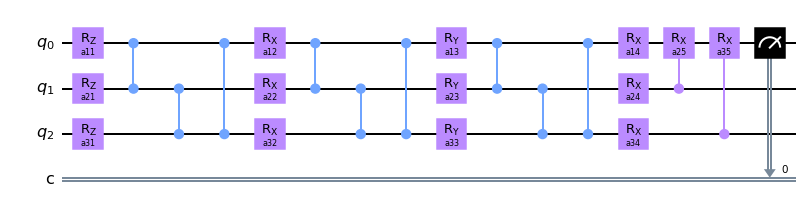

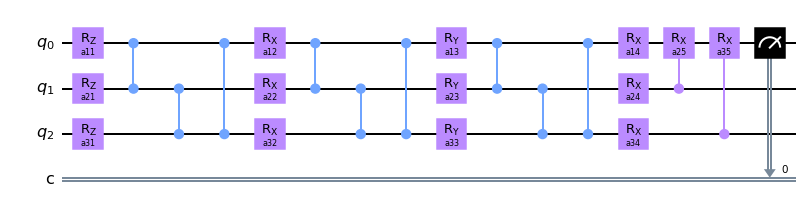

In [14]:
# create a quantum 4-layer-circuit and simulate input states by appending not-gates to the front
qc0 = QuantumCircuit(3, 1)
qc1 = QuantumCircuit(3, 1)
qc2 = QuantumCircuit(3, 1)
qc3 = QuantumCircuit(3, 1)
qc4 = QuantumCircuit(3, 1)
qc5 = QuantumCircuit(3, 1)
qc6 = QuantumCircuit(3, 1)
qc7 = QuantumCircuit(3, 1)
qcs = [qc0,qc1,qc2,qc3,qc4,qc5,qc6,qc7]

qc1.x(0)
qc2.x(1)
qc3.x(0)
qc3.x(1)
qc4.x(2)
qc5.x(0)
qc5.x(2)
qc6.x(1)
qc6.x(2)
qc7.x(0)
qc7.x(1)
qc7.x(2)

for i in range(8):
    qcs[i].rz(theta11,0)
    qcs[i].rz(theta21,1)
    qcs[i].rz(theta31,2)
    qcs[i].cz(0,1)
    qcs[i].cz(1,2)
    qcs[i].cz(2,0)
    qcs[i].rx(theta12,0)
    qcs[i].rx(theta22,1)
    qcs[i].rx(theta32,2)
    qcs[i].cz(0,1)
    qcs[i].cz(1,2)
    qcs[i].cz(2,0)
    qcs[i].ry(theta13,0)
    qcs[i].ry(theta23,1)
    qcs[i].ry(theta33,2)
    qcs[i].cz(0,1)
    qcs[i].cz(1,2)
    qcs[i].cz(2,0)
    qcs[i].rx(theta14,0)
    qcs[i].rx(theta24,1)
    qcs[i].rx(theta34,2)
    
    qcs[i].crx(theta25,1,0)
    qcs[i].crx(theta35,2,0)
    qcs[i].measure(range(1), range(1))

qcs[0].draw()

In [15]:
# algorithm part, similar to gradient decent method
shots = 1024
def counts2P(counts):
    p0 = counts.get('0')
    p1 = counts.get('1')
    r = [0,0]
    if p0 != None:
        r[0] = p0/shots
    if p1 != None:
        r[1] = p1/shots
    return r

def runCircuitReturnCounts(qc,thetas):
    circuitToRun = qc.bind_parameters({theta11: thetas[0], theta21: thetas[1], theta31: thetas[2],theta12: thetas[3], theta22: thetas[4], theta32: thetas[5],theta13: thetas[6], theta23: thetas[7], theta33: thetas[8],theta14: thetas[9], theta24: thetas[10], theta34: thetas[11], theta25: thetas[12], theta35: thetas[13]})
    job = execute(circuitToRun, backend=BasicAer.get_backend('qasm_simulator'),shots = shots)
    result = job.result()
    return result.get_counts()

def runCircuitReturnP(qc,thetas):
    return counts2P(runCircuitReturnCounts(qc,thetas))

def runCircuitReturnError(qc,thetas,target):
    p = runCircuitReturnP(qc,thetas)
    error = 1 - p[target]
    return error

def getGradient(qc,thetas,target):
    temp1 = thetas.copy()
    temp2 = thetas.copy()
    gradient = np.zeros(len(thetas))
    
    for i in range(len(thetas)):
        temp1[i] = temp1[i]+pi/4
        temp2[i] = temp2[i]-pi/4
        gradient[i] = runCircuitReturnError(qc,temp1,target) - runCircuitReturnError(qc,temp2,target)
        temp1[i] = temp1[i]-pi/4
        temp2[i] = temp2[i]+pi/4
    return gradient

def getTarget(init,goalOutput):
    t = 0
    if goalOutput[0] != init[0]:
        t = t + 4
    if goalOutput[1] != init[1]:
        t = t + 2
    if goalOutput[2] != init[2]:
        t = t + 1
    r = [0,0,0,0,0,0,0,0]
    r[t] = 1
    return r

def string2Int(s):
    i = 0
    if s[0] != '0':
        i = i + 1
    return i

def string2Int3(s):
    i = 0
    if s[0] != '0':
        i = i + 4
    if s[1] != '0':
        i = i + 2
    if s[2] != '0':
        i = i + 1
    return i

def learnOnce(thetas,data,learningRate,showError):
    qcCount = string2Int3(data[0])
    if showError:
        print('Error: ', end = '')
        print(runCircuitReturnError(qcs[qcCount],thetas,string2Int(data[1])))
    gradient = getGradient(qcs[qcCount],thetas,string2Int(data[1]))
    
    for i in range(len(thetas)):
        thetas[i] = thetas[i] - learningRate*gradient[i]
    return None

# in an iteration  step, each data pair will be learned once
def letsLearn(thetas,learningTimes,learningRate,showError):
    for i in range(learningTimes):
        print('this is step ' + str(i))
        for j in range(len(dataset)):
            learnOnce(thetas,dataset[j],learningRate,showError)
    return None

In [ ]:
# create database for learning: [inputState,outputState]
data1 = ['000','0']
data2 = ['101','1']
data3 = ['011','0']
data4 = ['110','1']
dataset = [data1,data2,data3,data4]

thetas = [pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3,pi/3]
LR = 0.2*pi
letsLearn(thetas,10,LR,False)

# show circuit's performance after learning
print("thetas:")
print(thetas)
print("000->")
print(runCircuitReturnCounts(qcs[0],thetas))
print("001->")
print(runCircuitReturnCounts(qcs[1],thetas))
print("010->")
print(runCircuitReturnCounts(qcs[2],thetas))
print("011->")
print(runCircuitReturnCounts(qcs[3],thetas))
print("100->")
print(runCircuitReturnCounts(qcs[4],thetas))
print("101->")
print(runCircuitReturnCounts(qcs[5],thetas))
print("110->")
print(runCircuitReturnCounts(qcs[6],thetas))
print("111->")
print(runCircuitReturnCounts(qcs[7],thetas))

this is step 0
